In [1]:
# PLEASE NOTE - THERE ARE TWO NOTEBOOKS IN LAB 3!

# This notebook is for working through some classifier comparison techniques 
# it corresponds to Lecture Handouts 3 and 4.
#
# The questions are:
#  -- Section 1: binary (two-class) classification (notebook: Lab 3 Ex. 1)  -- 
#   i) Evaluate & compare the ROC curves for different classifiers.
#  ii) Influence the classifier performance by introducing class weights.
#
#  -- Section 2: multi-class classification (notebook: Lab 3 Ex. 2) --
# iii) Evaluate & compare classifiers using the confusion matrix.
#  iv) Classifier selection with practical criteria.

In [2]:
# Autoload setup (you don't need to edit this cell); instructions to: 
#   i) enable autoreloading of modules
%load_ext autoreload
#  ii) import the module 'lab_3' (which will contain your functions) in an autoreloadable way 
%aimport lab_3
# iii) indicate that we want autoreloading to happen on every evaluation.
%autoreload 1

In [3]:
##############################################################
#
# Module import -- see Ex. 1 notebook.
#
##############################################################
import pandas as pd
import numpy as np
import sklearn as skl
import time
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7

import sklearn.linear_model as skl_lm

from sklearn.datasets import fetch_mldata
from sklearn.utils import check_random_state

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

import time



In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          show_values=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    ax = plt.figure(figsize=(10, 10)).add_subplot(111)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.02, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    if (show_values):
        fmt = '.2f' if normalize else 'd'
        thresh = 2*cm.max() / 3.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# We are using off the shelf classifiers from the sklearn package
classifiers = {
    'Nearest Neighbors': KNeighborsClassifier(3),
    'Multinomial Logistic': LogisticRegression(C=50.0 / 5000,
                                multi_class='multinomial',
                                solver='newton-cg', tol=0.2),
    'Linear SVM' : SVC(kernel="linear", C=0.025, probability=True),
    'RBF SVM'    : SVC(C=5, gamma=0.05, probability=True),
    'Decision Tree' : DecisionTreeClassifier(max_depth=5)
}


In [6]:
#  
# Going Further: MultiClass Classification on the MNIST Dataset 
# using the Multinomial Logistic Regression
# 
# Loading the MNIST dataset
train_samples = 2000

mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float')/255
# X = StandardScaler().fit_transform(X)  # don't do this --- it makes every pixel equally significant!
y = mnist.target
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

# splitting the dataset into training set and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=500, random_state=0)

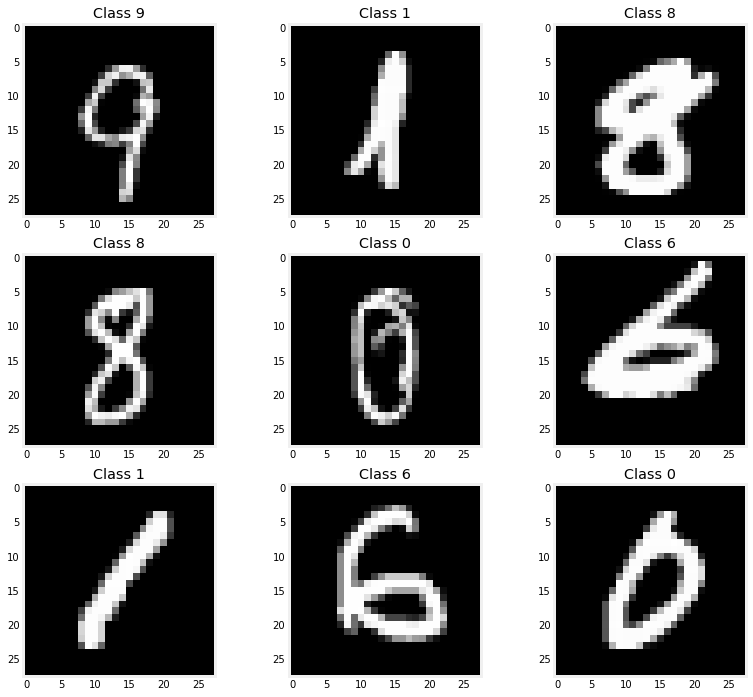

In [7]:
# showing some of the examples in the dataset

fig, ax = plt.subplots(3,3, figsize=(12,12))

for i in range(9):
    picture = np.reshape(X_train[i], (28, 28))

    plt.subplot(3,3,i+1)
    plt.imshow(picture, cmap='gray', interpolation='none')
    plt.gca().grid(False) 
    plt.title("Class {}".format(int(y_train[i])))

In [8]:
metrics = {}

for name, classifier in classifiers.items():    

    print('training for classifer: {}'.format(name))
    start_time = time.time()
    classifier.fit(X_train, y_train)
    end_time = time.time()
    
    m = {}
    m['training_time'] = end_time - start_time
    metrics[name] = m

print("done")

training for classifer: Nearest Neighbors
training for classifer: Multinomial Logistic
training for classifer: Linear SVM
training for classifer: RBF SVM
training for classifer: Decision Tree
done


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_test = y_test.reshape(y_test.shape[0], 1)
for name, classifier in classifiers.items():  
    print('predictions for classifer: {}'.format(name))
    start_time = time.time()
    y_pred = classifier.predict(X_test)
    y_pred = y_pred.reshape(y_pred.shape[0], 1)
    end_time = time.time()
    #print("y_test: ", y_test.shape)
    #print("y_pred: ", y_pred.shape)
    m = {}
    m['f1'] = f1_score(y_test, y_pred, average='macro')
    m['accuracy'] = accuracy_score(y_test, y_pred)
    m['Misclassification'] = 1 - m['accuracy']
    m['precision'] = precision_score(y_test, y_pred, average='macro')
    m['recall'] = recall_score(y_test, y_pred, average='macro')
    m['prediction_time'] = end_time - start_time
    metrics[name].update(m)
print("done")


predictions for classifer: Nearest Neighbors
predictions for classifer: Multinomial Logistic
predictions for classifer: Linear SVM
predictions for classifer: RBF SVM
predictions for classifer: Decision Tree
done


In [10]:
df = pd.DataFrame(metrics).transpose()
display(df)


,Misclassification,accuracy,f1,precision,prediction_time,recall,training_time
Nearest Neighbors,0.080,0.920,0.918661,0.923073,2.007237,0.917445,0.064338
Multinomial Logistic,0.136,0.864,0.860817,0.865882,0.002203,0.860016,1.262041
Linear SVM,0.106,0.894,0.891544,0.894479,0.672111,0.891254,9.719118
RBF SVM,0.062,0.938,0.934887,0.935974,1.164028,0.936201,40.460677
Decision Tree,0.374,0.626,0.611138,0.617194,0.001556,0.617893,0.178811


In [11]:
# Question:
# What percentage of images in the test set are misclassified by the RBF SVM classifier?
#
# Provide your answer in the function 'question_3' in the lab module ('lab_3.py').


Normalized confusion matrix
[[ 0.947  0.000  0.000  0.000  0.000  0.000  0.026  0.000  0.026  0.000]
 [ 0.000  0.985  0.015  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.024  0.000  0.976  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.019  0.962  0.000  0.019  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.022  0.957  0.022  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.038  0.962  0.000  0.000  0.000]
 [ 0.042  0.021  0.042  0.000  0.000  0.000  0.000  0.812  0.042  0.042]
 [ 0.000  0.019  0.019  0.019  0.000  0.000  0.038  0.000  0.906  0.000]
 [ 0.000  0.000  0.042  0.021  0.021  0.000  0.000  0.062  0.000  0.854]]


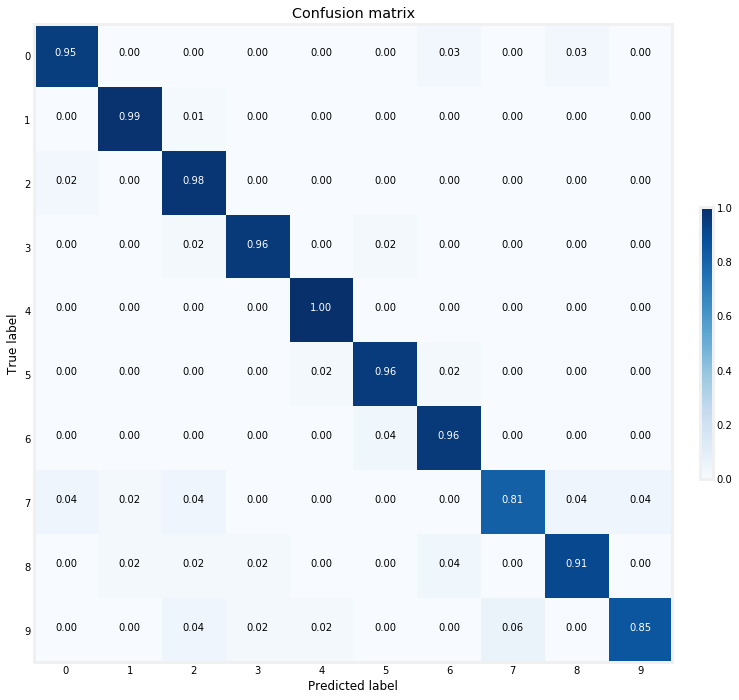

In [12]:
# Examine the performance of the RBF SVM classifier via the confusion matrix.

predicted_classes = classifiers['RBF SVM'].predict(X_test)

M = skl.metrics.confusion_matrix(y_test, predicted_classes)

class_names = [str(n) for n in range(0,10)]
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
plot_confusion_matrix(M, class_names, normalize=True, show_values=True)

In [13]:
# Question:
# Which digit is most frequently misclassified?
#
# Provide your answer in the function 'question_4' in the lab module ('lab_3.py').